In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import math

# TEST ASSUMPTIONS
import statsmodels.stats.api as sms # homoskedasticity
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white # homoskedasticity
from scipy.stats import bartlett # homoskedasticity
from scipy.stats import normaltest # for normal distribution
from statsmodels.stats import diagnostic as diag # autocorellation (not so important)
import statsmodels.api as sm # autocorellation (not so important)

# LASSO model selection
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso

# CREATED FUNCTIONS
from ufc_func import *

# OUTLIERS
from scipy import stats

In [2]:
df = pd.read_csv("./ufc.csv")
df = pd.DataFrame(df)
df

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith
7413,"Denver, Colorado, USA",Frank Hamaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Morris
7414,"Denver, Colorado, USA",Johnny Rhodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7415,"Denver, Colorado, USA",Patrick Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our dataframe contains some null rows, so will need to remove it. Additionally column with "Time" doesn't useful for our aims in this represantation. We need to convert it to another units (to seconds).

In [3]:
df = df.dropna()
df_with_time = df.copy()

df_with_time["Seconds"] = df_with_time["Time"].apply(time_converter) + df_with_time["Round"].apply(round_converter)
df_with_time


,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0


Also some there are some "strange" fights: fighter 1 and fighter 2 both loss in fight.

In [4]:
df_with_time.tail(10)

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
7403,"Denver, Colorado, USA",Royce Gracie,Fred Ettish,1.0,0.0,13.0,4.0,0.0,0.0,1.0,0.0,Open Weight,SUB Bulldog Choke,1.0,3:07,UFC 2,11-Mar-94,Remco Pardoel,187.0
7404,"Denver, Colorado, USA",Patrick Smith,Scott Morris,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,Open Weight,KO/TKO Elbows,1.0,0:30,UFC 2,11-Mar-94,Johnny Rhodes,30.0
7405,"Denver, Colorado, USA",Royce Gracie,Minoki Ichihara,0.0,0.0,2.0,3.0,1.0,0.0,2.0,0.0,Open Weight,SUB Armbar,1.0,5:08,UFC 2,11-Mar-94,Patrick Smith,308.0
7406,"Denver, Colorado, USA",Remco Pardoel,Scott Baker,0.0,0.0,3.0,0.0,0.0,1.0,5.0,0.0,Open Weight,SUB Triangle Choke,1.0,6:41,UFC 2,11-Mar-94,Royce Gracie,401.0
7407,"Denver, Colorado, USA",Johnny Rhodes,Alberta Cerra Leon,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,Open Weight,SUB Ezekiel Choke,1.0,9:51,UFC 2,11-Mar-94,Jason DeLucia,591.0
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith,20.0


We need to remove it

In [5]:
df_with_time = df_with_time.loc[
    (df_with_time["Fighter 1"] == df_with_time["Winner"]) | 
    (df_with_time["Fighter 1"] == df_with_time["Winner"])].reset_index(drop=True)

Next, let us show average statistic per fight (including first and second fighter)

In [6]:
total_kd = (df["Fighter_1_KD"] + df["Fighter_2_KD"]).mean()
total_str= (df["Fighter_1_STR"] + df["Fighter_2_STR"]).mean()
total_td= (df["Fighter_1_TD"] + df["Fighter_2_TD"]).mean()
total_sub= (df["Fighter_1_SUB"] + df["Fighter_1_SUB"]).mean()

print("Average knockdowns per fight: ", total_kd)
print("Average significant strikes per fight: ", total_str)
print("Average takedown attemps per fight: ", total_td)
print("Average submissions attemps per fight: ", total_sub)

Average knockdowns per fight:  0.4305180787911495
Average significant strikes per fight:  71.68497031840259
Average takedown attemps per fight:  2.1184565569347007
Average submissions attemps per fight:  1.0642201834862386


As we can see knockdowns is the rarest fight moment. Now let us look what type of finishes UFC fight can have:

In [7]:
methods = df_with_time["Method"].unique()

methods

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'Overturned', 'KO/TKO Elbows',
       'KO/TKO Kick', 'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC',
       'SUB Arm Triangle', 'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'DQ',
       'SUB Anaconda Choke', 'SUB Ezekiel Choke', 'SUB Triangle Choke',
       'SUB Twister', 'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'Overturned Guillotine Choke',
       'KO/TKO Elbow', 'SUB Other - Lock', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'Overturned Punches',
       'SUB Ankle Lock', 'SUB Forearm Choke', 'SUB Injury',
       'Overturned Punch', 'Overturned Rear Naked Choke',
       'Overturned Knee', 'O

There are lots of different type of finishes, but all them come down to KO/TKO, SUB, DEC, CNC. Overturned, Other and DQ are useless characteristic for our research.

In [8]:
df_fil = methods_destroyer(df_with_time)

df_fil["Method"].unique()

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'KO/TKO Elbows', 'KO/TKO Kick',
       'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC', 'SUB Arm Triangle',
       'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'SUB Anaconda Choke',
       'SUB Ezekiel Choke', 'SUB Triangle Choke', 'SUB Twister',
       'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'KO/TKO Elbow', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'SUB Ankle Lock',
       'SUB Forearm Choke', 'SUB Injury', 'SUB Peruvian Necktie',
       'SUB Schultz Front Headlock', 'SUB Bulldog Choke',
       'SUB Suloev Stretch', 'SUB Omoplata', 'SUB Calf Slicer',
       'SUB North-South Choke', 'SUB Pac

Now this data can be useful, we can plot distribution of methods if we remove additional information, like "Armbar", "Punch" and so on.

In [9]:
df_methods = df_fil.copy()
df_methods["Method"] = df_fil["Method"].apply(replace_method)
df_methods["Method"].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

Now we can plot histogram of distribtuion

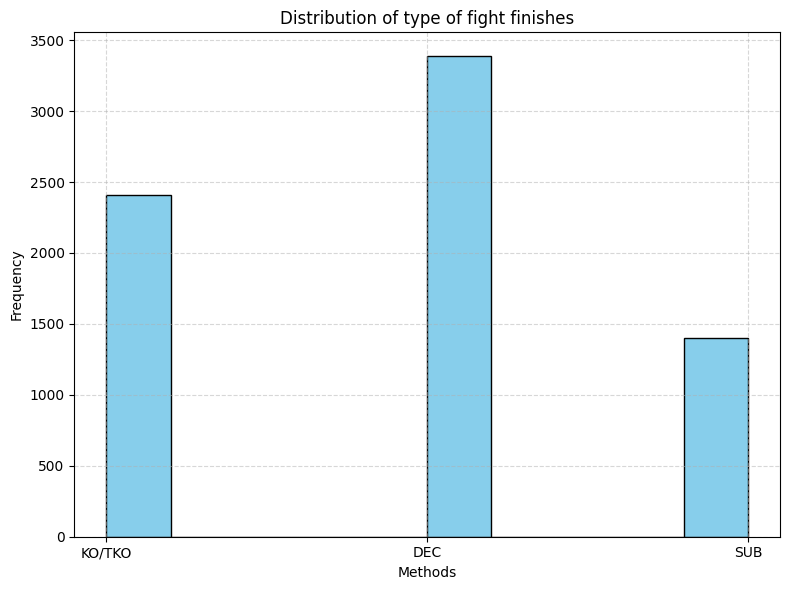

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(df_methods["Method"], color='skyblue', edgecolor='black')
plt.title('Distribution of type of fight finishes')
plt.xlabel('Methods')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now let us take a look at "Weight_Class".

In [11]:
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       'Catch Weight', "Women's Featherweight", 'Super Heavyweight',
       'Open Weight'], dtype=object)

Some of these categories are not used in UFC, so we will drop them 

In [12]:
df_fil = weight_destroyer(df_fil)
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       "Women's Featherweight"], dtype=object)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

In [13]:
three, five = df_breaker_by_rounds(df_fil)

df_fil = three.copy()

df_fil

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,"Mobile, Alabama, USA",Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,Middleweight,S-DEC,2.0,3:00,UFC 17,15-May-98,Dan Henderson,480.0
7263,"Mobile, Alabama, USA",David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,Heavyweight,KO/TKO Punches,1.0,0:43,UFC 17,15-May-98,David Abbott,43.0
7264,"Mobile, Alabama, USA",Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,Heavyweight,SUB Keylock,1.0,11:01,UFC 17,15-May-98,Mike van Arsdale,661.0
7265,"Mobile, Alabama, USA",Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,Middleweight,SUB Triangle Choke,1.0,0:52,UFC 17,15-May-98,Carlos Newton,52.0


Now, we are going to remove all unneccassary columns: Date (data doesn't depend on date), Event Name, Round, Time, Location.

In [14]:
df_fil = de_remover(df_fil)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

Finally, our dataframe is ready to be used in project. But before, we will run logit and OLS models, let us create dataframe with fighters statistic.

In [15]:
fighters = list(set(df_fil["Fighter 1"].unique()).union(set(df_fil["Fighter 2"].unique())))
fighters_df = pd.DataFrame({"Fighter_name": [],
                            "Average_significant_strikes": [],
                            "Average_takedowns": [],
                            "Average_submission_attempts": [],
                            "Average_knockdowns": [],
                            "Average_activity": [],
                            "Wins": [],
                            "Loss": [],
                            "Winrate": []})


for ele in fighters:
    win_df = df_fil.loc[df_fil["Fighter 1"] == ele]
    lose_df = df_fil.loc[df_fil["Fighter 2"] == ele]

    wins, losses = int(len(win_df.index)), int(len(lose_df.index))

    amount_of_mentions = wins + losses

    avg_strk = round((win_df["Fighter_1_STR"].sum() + lose_df["Fighter_2_STR"].sum())/amount_of_mentions, 2)
    avg_tkd = round((win_df["Fighter_1_TD"].sum() + lose_df["Fighter_2_TD"].sum())/amount_of_mentions, 2)
    avg_subs = round((win_df["Fighter_1_SUB"].sum() + lose_df["Fighter_2_SUB"].sum())/amount_of_mentions, 2)
    avg_kd = round((win_df["Fighter_1_KD"].sum() + lose_df["Fighter_2_KD"].sum())/amount_of_mentions, 2)
    # weight_class = pd.concat([lose_df["Weight_Class"], win_df["Weight_Class"]])

    avg_act = avg_strk + avg_tkd + avg_subs + avg_kd

    data = {
        "Fighter_name": [ele],
        "Average_significant_strikes": [avg_strk],
        "Average_takedowns": [avg_tkd],
        "Average_submission_attempts": [avg_subs],
        "Average_knockdowns": [avg_kd],
        "Average_activity": [avg_act],
        "Wins": [wins],
        "Loss": [losses],
        "Winrate": [round(wins/(wins+losses), 2)],
        # "Weight_class": [weight_class.unique()]
    }

    fighters_df = pd.concat([fighters_df, pd.DataFrame(data)], ignore_index = True)

fighters_df

,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate
0,Gregory Rodrigues,46.14,1.29,0.29,0.57,48.29,5.0,2.0,0.71
1,Kyler Phillips,67.67,2.50,0.50,0.33,71.00,5.0,1.0,0.83
2,Buddy Roberts,25.00,0.00,0.50,0.00,25.50,1.0,1.0,0.50
3,Chris de la Rocha,30.25,1.00,0.50,0.00,31.75,1.0,3.0,0.25
4,Rich Attonito,27.60,0.60,0.00,0.40,28.60,3.0,2.0,0.60
...,...,...,...,...,...,...,...,...,...
2308,Ryo Chonan,38.00,0.50,0.00,0.00,38.50,1.0,3.0,0.25
2309,Damien Brown,40.33,0.50,0.50,0.33,41.66,2.0,4.0,0.33
2310,Aliaskhab Khizriev,42.00,2.00,1.00,0.00,45.00,1.0,0.0,1.00
2311,Daniel Pineda,24.83,0.92,0.92,0.17,26.84,5.0,7.0,0.42


In [16]:
fighters_df = pd.read_csv("./app/data/fighter.csv")

fighters_df = pd.DataFrame(fighters_df)

fighter_weight = fighters_df[fighters_df["Weight_class"].apply(lambda x: "Welterweight" in x)].reset_index(drop=True)

fighter_weight['Fighter_name'].to_list()

['Alexander Yakovlev',
 'Rodrigo de Lima',
 'Sean Spencer',
 'Nathan Coy',
 'Ryan McGillivray',
 'Yancy Medeiros',
 'Mike Rhodes',
 'Shavkat Rakhmonov',
 'Darrius Flowers',
 'Josh Neer',
 'John Howard',
 'Dan Stittgen',
 'Che Mills',
 'Hernani Perpetuo',
 'Sean Brady',
 'Adrian Serrano',
 'John Alessio',
 'Francisco Trinaldo',
 'James Head',
 'Chris Wilson',
 'Tom Breese',
 'Marcio Alexandre Junior',
 'Wendell Oliveira Marques',
 'Jon Manley',
 'Chris Brennan',
 'Stephen Thompson',
 'Bojan Velickovic',
 'Ben Alloway',
 'Matthew Riddle',
 'Ramsey Nijem',
 'Rostem Akman',
 'Rafael Dos Anjos',
 'Zak Ottow',
 'Brandon Thatch',
 'Clay Harvison',
 'Ricardo Almeida',
 'Rich Attonito',
 'Kyle Noke',
 'Lyman Good',
 'Matt Brown',
 'Amir Sadollah',
 'Alex Morono',
 'Joe Stevenson',
 'Khamzat Chimaev',
 'Jonathan Meunier',
 'Kyle Bradley',
 'Paul Bradley',
 'Jake Hecht',
 'Jason Gilliam',
 'Nate Marquardt',
 'Justin Edwards',
 'Kyle Prepolec',
 'Micheal Gillmore',
 'Kamaru Usman',
 'Gil Castillo'

In [17]:
fighters_df

,Unnamed: 0,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate,Weight_class
0,0,Irwin Rivera,50.33,1.00,0.00,0.00,51.33,1.0,2.0,0.33,['Bantamweight' 'Featherweight']
1,1,Nathaniel Wood,69.89,1.67,0.44,0.22,72.22,7.0,2.0,0.78,['Featherweight' 'Bantamweight']
2,2,Ricardo Ramos,29.82,1.73,0.45,0.27,32.27,7.0,4.0,0.64,['Featherweight' 'Bantamweight']
3,3,Mara Romero Borella,23.86,1.14,0.14,0.00,25.14,2.0,5.0,0.29,"[""Women's Flyweight""]"
4,4,Edmen Shahbazyan,27.00,1.22,0.33,0.33,28.88,5.0,4.0,0.56,['Middleweight']
...,...,...,...,...,...,...,...,...,...,...,...
2308,2308,Dan Ige,44.00,0.85,0.08,0.38,45.31,9.0,4.0,0.69,['Featherweight']
2309,2309,Melissa Gatto,50.50,1.00,0.25,0.25,52.00,2.0,2.0,0.50,"[""Women's Flyweight""]"
2310,2310,Kamuela Kirk,35.33,1.00,1.33,0.00,37.66,1.0,2.0,0.33,['Lightweight' 'Featherweight']
2311,2311,Caio Magalhaes,18.43,0.57,0.86,0.29,20.15,4.0,3.0,0.57,['Middleweight']


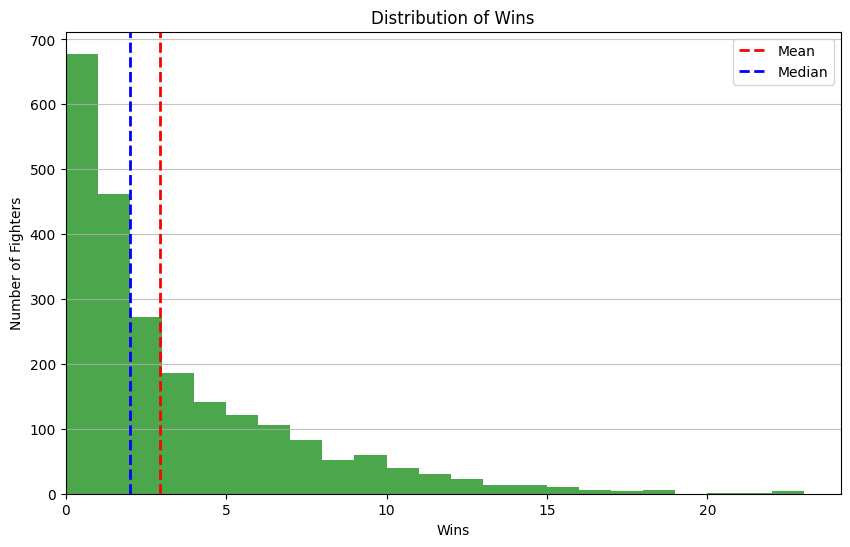

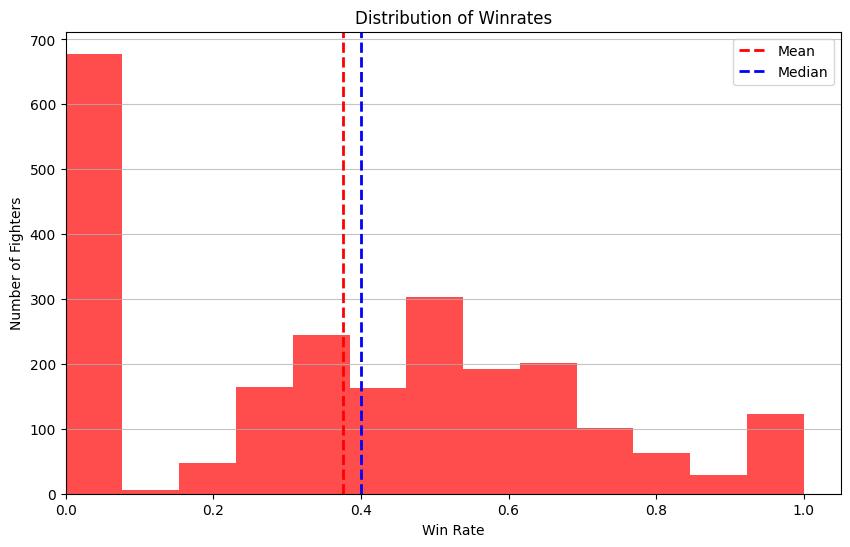

In [18]:
mean_wins = fighters_df["Wins"].mean()
median_wins = fighters_df["Wins"].median()

plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Wins"], bins=int(fighters_df["Wins"].max()), color='green', alpha=0.7)
plt.title('Distribution of Wins')
plt.xlabel('Wins')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wins, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wins, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()

plt.show()

mean_wr = fighters_df["Winrate"].mean()
median_wr = fighters_df["Winrate"].median()
plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Winrate"], bins='auto', color='red', alpha=0.7)
plt.title('Distribution of Winrates')
plt.xlabel('Win Rate')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wr, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wr, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()
plt.show()

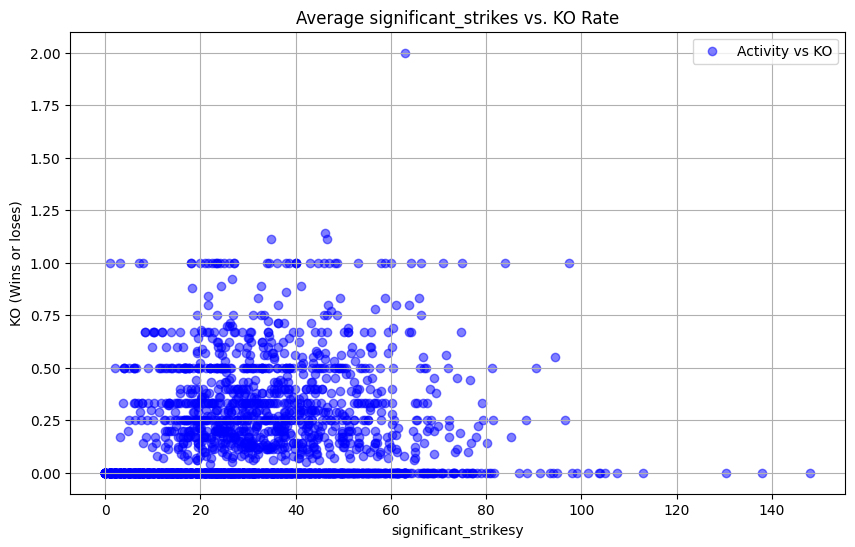

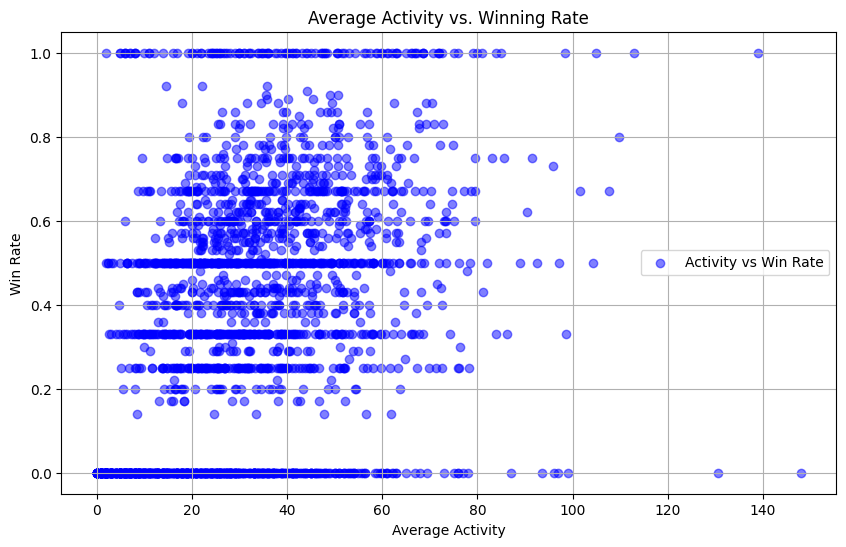

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_significant_strikes"], fighters_df["Average_knockdowns"], color='blue', alpha=0.5, label='Activity vs KO')
plt.title('Average significant_strikes vs. KO Rate')
plt.xlabel('significant_strikesy')
plt.ylabel('KO (Wins or loses)')
plt.legend()
plt.grid(True)
plt.show()

# Improved Scatter plot for Average Activity vs. Win Rate
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_activity"], fighters_df["Winrate"], color='blue', alpha=0.5, label='Activity vs Win Rate')
plt.title('Average Activity vs. Winning Rate')
plt.xlabel('Average Activity')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# cor_df = fighters_df.drop(["Fighter_name"], axis=1)
# correlation_matrix = cor_df.corr()


# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
# plt.title('Correlation Matrix of Fighter Statistics')
# plt.show()

# OLS

Now, we are going to construct OLS method for predicting the duration of fight in seconds. However, our dataframe contains male and female fighters and it is not relevant to predict duration fight in combined dataframe, because man and woman can not have much up in UFC, so we are going to divide dataframe in two: for males and for females

In [21]:
df_fil["Gender"] = np.where(df_fil["Weight_Class"].str.contains("Women"), 1, 0)
df_man = df_fil.loc[df_fil["Gender"] == 0].drop(["Gender"], axis=1).reset_index(drop=True)
df_woman = df_fil.loc[df_fil["Gender"] != 0].drop(["Gender"], axis=1).reset_index(drop=True)

Variables in "Weight_Class" is ordinal, so to make our future OLS more relevent, we need to divide this column to many distinct columns. Each this column will represent the distinct weight category, so if fighters belong to this category we will put 1, if not 0 (It is clear that fighters in one fight can only belongs to one category).

In [22]:
df_man_clear = weight_breaker(df_man)
df_woman_clear = weight_breaker(df_woman)

df_man_clear

,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Winner,Seconds,Lightweight,Bantamweight,Welterweight,Middleweight,Light Heavyweight,Featherweight,Heavyweight,Flyweight
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,Arman Tsarukyan,64.0,1,0,0,0,0,0,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,Jalin Turner,169.0,1,0,0,0,0,0,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,Deiveson Figueiredo,900.0,0,1,0,0,0,0,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,Sean Brady,703.0,0,0,1,0,0,0,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,Joaquim Silva,900.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,Dan Henderson,480.0,0,0,0,1,0,0,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,David Abbott,43.0,0,0,0,0,0,0,1,0
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,Mike van Arsdale,661.0,0,0,0,0,0,0,1,0
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,Carlos Newton,52.0,0,0,0,1,0,0,0,0


In [23]:
winrates_df = history_winrate(df_man_clear)

In [24]:


names = [ele.replace(" ", "_") for ele in winrates_df.columns.to_list()]
winrates_df.columns = names

winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Lightweight,Bantamweight,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.88,0.77
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.59
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0.75,0.75
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0.83,0.75
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1.00,1.00
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0.00,0.00


In [25]:
categories_all = [ele for ele in winrates_df.columns if "Fighter" in ele or "winrate" in ele]
categories = [(categories_all[i], categories_all[i+1]) for i in range(0, len(categories_all), 2)]

swapper(winrates_df, categories)



We have lots of zeroes in this dataframe so let us try to remove them or make more meaningful

In [26]:
winrates_df['Winrate_1_is_0'] = np.where(winrates_df["Current_winrate_F1"] == 0, 1, 0)
winrates_df['Winrate_2_is_0'] = np.where(winrates_df["Current_winrate_F2"] == 0, 1, 0)

In [27]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Carlos Newton,Dan Henderson,2.0,0.0,20.0,28.0,2.0,3.0,1.0,0.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Bob Gilstrap,Carlos Newton,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# OLS

In [28]:
winrates_df["Seconds"].value_counts()

Seconds
900.0    2686
600.0      39
300.0      20
299.0      20
255.0      15
         ... 
319.0       1
390.0       1
701.0       1
670.0       1
601.0       1
Name: count, Length: 820, dtype: int64

In [29]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_Time=smf.ols(f"Seconds ~ {' + '.join(winrates_df_model)}", data=winrates_df)
print(model_Time.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     581.2
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:29:05   Log-Likelihood:                -41058.
No. Observations:                6136   AIC:                         8.216e+04
Df Residuals:                    6116   BIC:                         8.229e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.6093     15

Now It is seem that weight class in unsignificant variable, so let test their joint significance

In [30]:
weights = winrates_df[['Bantamweight', 'Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight']]

test_model = smf.ols(formula=f"Seconds ~ {' + '.join(weights.columns)}", data=winrates_df).fit()

f_statistic = test_model.fvalue
p_value = test_model.f_pvalue


if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


It seems their are significant. Now let perform model selection with AIC to create the best model

In [31]:
# LASSO SELECTION IS DONE
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(winrates_df_model, winrates_df["Seconds"])
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


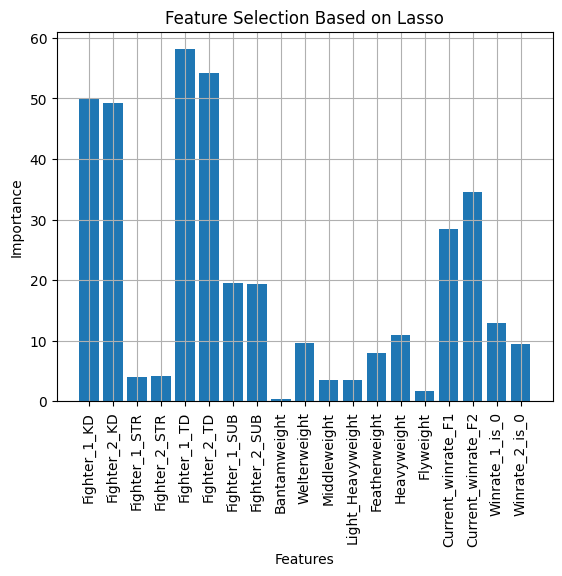

In [32]:

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(winrates_df_model, winrates_df["Seconds"])

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

names = winrates_df_model.columns
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [33]:

selected_model = winrates_df_model[np.array(names)[lasso1_coef>3]]

selected_model

,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.88,0.77,0,0
1,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.59,0.56,0,0
2,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,0,0,0,0,0,0.75,0.75,0,0
3,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,1,0,0,0,0,0.75,0.83,0,0
4,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,2.0,0.0,20.0,28.0,2.0,3.0,1.0,0.0,0,1,0,0,0,1.00,1.00,0,0
6132,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1,0.00,0.00,1,1
6133,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,0,0,0,0,1,0.00,0.00,1,1
6134,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0,1,0,0,0,0.00,0.00,1,1


In [34]:
model_Time_selected=smf.ols(f"Seconds ~ {' + '.join(selected_model)}", data=winrates_df).fit().summary()

model_Time_selected

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     649.8
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:29:07   Log-Likelihood:                -41058.
No. Observations:                6136   AIC:                         8.215e+04
Df Residuals:                    6118   BIC:                         8.227e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.8671     14.742     11.930      0.000     146.968     204.766
Fighter_1_KD         -50.0540      5.113     -9.790      0.000     -60.077     -40.031
Fighter_2_KD         -49.2318      5.287     -9.312      0.000     -59.596     -38.868
Fighter_1_STR          4.0465      0.120     33.814      0.000       3.812       4.281
Fighter_2_STR          4.1181      0.120     34.223      0.000       3.882       4.354
Fighter_1_TD          58.1242      1.619     35.894      0.000      54.950      61.299
Fighter_2_TD          54.1080      1.583     34.183      0.000      51.005      57.211
Fighter_1_SUB         19.4420      3.033      6.410      0.000      13.496      25.388
Fighter_2_SUB         19.3554      3.065      6.316      0.000      13.348      25.363
Welterweight           9.2576      7.111      1.302      0.193      -4.683      23.198
Middleweight           3.1146      7.696      0.405      0.686     -11.972      18.202
Light_Heavyweight     -3.4563     11.154     -0.310      0.757     -25.321      18.409
Featherweight         -8.2562      8.649     -0.955      0.340     -25.211       8.699
Heavyweight          -11.2344      9.060     -1.240      0.215     -28.995       6.526
Current_winrate_F1    28.4059     14.174      2.004      0.045       0.620      56.192
Current_winrate_F2    34.5754     14.453      2.392      0.017       6.242      62.909
Winrate_1_is_0        12.9574     11.242      1.153      0.249      -9.080      34.995
Winrate_2_is_0         9.4013     11.379      0.826      0.409     -12.906      31.708
==============================================================================
Omnibus:                       44.655   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.582
Skew:                           0.195   Prob(JB):                     2.09e-10
Kurtosis:                       2.853   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us calculate accuracy score for OLS model. To do it, we will need to convert preditions of variable "Second" into ordinal variable "Round" (the same we will need to perform with true values, because column "Round" was dropped at the beginning of research), however accuracy score is bad in distinguish between different classes so we will use f1 score for this purposes

In [35]:
predictor_data = winrates_df_model

predictions = model_Time.fit().predict(predictor_data)

print(predictions)

0       217.741449
1       359.040999
2       827.103202
3       694.224702
4       836.357749
           ...    
6131    636.088923
6132    285.619774
6133    409.631325
6134    317.621177
6135    448.821703
Length: 6136, dtype: float64


In [36]:
accuracy_win = winrates_df.copy()

accuracy_win["Second_Pred"] = predictions
accuracy_win["Round_Pred"] = accuracy_win["Second_Pred"].apply(second_to_round)
accuracy_win["Round"] = accuracy_win["Seconds"].apply(second_to_round)

conf_mat = metrics.confusion_matrix(accuracy_win["Round"], accuracy_win["Round_Pred"])
f_1_score = metrics.f1_score(accuracy_win["Round"], accuracy_win["Round_Pred"], average="macro")

pred_accuracy = (accuracy_win["Round_Pred"] == accuracy_win["Round"]).value_counts()

print(f"Accuracy: {round(pred_accuracy[0]/(pred_accuracy[0]+pred_accuracy[1]),2)}")

Accuracy: 0.58


In [37]:
winrates_df["Winner"] = pd.to_numeric(winrates_df["Winner"])

In [38]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.0,0.0,18.0,14.0,0.0,5.0,0.0,3.0,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Carlos Newton,Dan Henderson,2.0,0.0,20.0,28.0,2.0,3.0,1.0,0.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Bob Gilstrap,Carlos Newton,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# Logit

In [39]:
winrates_df_model_logit = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=winrates_df)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.333332
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Fri, 19 Apr 2024   Pseudo R-squ.:                  0.5191
Time:                        13:29:07   Log-Likelihood:                -2045.3
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4155      0.237      1.752      0.080      -0.049       0.880
Fight

Let's calculate the accuracy score for logit model

In [40]:
predictor_data_logit = winrates_df_model_logit

predictions_logit = model_logit.fit().predict(predictor_data_logit)

Optimization terminated successfully.
         Current function value: 0.333332
         Iterations 7


Calculate the accuracy score for logit model

In [41]:
predictions_logit = np.where(predictions_logit > 0.5, 1, 0)

tp_and_fp = (winrates_df["Winner"] == predictions_logit).value_counts()

print(f"The accuracy score fot logit model: {(tp_and_fp[0]/(tp_and_fp[0]+tp_and_fp[1]))}")

The accuracy score fot logit model: 0.872555410691004


In [42]:
metrics.f1_score(winrates_df['Winner'], predictions_logit)

0.8740740740740741

In [43]:
history_avg = winrates_df.copy()

replace_stats_with_avg(history_avg)

history_avg

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,0.12,0.32,46.62,35.09,3.38,1.18,0.00,0.55,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.18,0.33,74.73,38.89,0.91,0.33,0.23,0.67,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Deiveson Figueiredo,Rob Font,0.67,0.58,24.42,46.25,1.00,0.67,1.67,0.42,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Kelvin Gastelum,Sean Brady,0.31,0.17,44.88,52.17,0.94,2.33,0.12,0.67,...,1,0,0,0,0,0,0.75,0.83,0,0
4,Joaquim Silva,Clay Guida,0.22,0.18,35.44,31.26,0.11,2.24,0.33,0.47,...,0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Carlos Newton,Dan Henderson,0.00,1.00,1.00,31.00,1.00,1.00,3.00,1.00,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,David Abbott,Hugo Duarte,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Mike van Arsdale,Joe Pardo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Bob Gilstrap,Carlos Newton,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0.00,0.00,1,1


Run new logit model for history_avg dataframe

In [44]:
model_logit2=smf.logit(f"Winner ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_logit2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.674228
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Fri, 19 Apr 2024   Pseudo R-squ.:                 0.02726
Time:                        13:29:19   Log-Likelihood:                -4137.1
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                 1.445e-38
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1210      0.163     -0.742      0.458      -0.441       0.199
Fight

In [45]:
model_Time2=smf.ols(f"Seconds ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_Time2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     13.86
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           6.56e-44
Time:                        13:29:19   Log-Likelihood:                -44094.
No. Observations:                6136   AIC:                         8.823e+04
Df Residuals:                    6116   BIC:                         8.836e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            574.5042     25

# Some additional functions to work with dataframe

In [46]:
get_stats_of_fighter(fighters_df, "Arman Tsarukyan")
get_fights_of_fighter(winrates_df, "Arman Tsarukyan")

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
193,Arman Tsarukyan,Joaquim Silva,0.0,0.0,80.0,23.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.86,0.62,0,0
376,Arman Tsarukyan,Damir Ismagulov,0.0,0.0,34.0,36.0,7.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.83,1.00,0,0
705,Joel Alvarez,Arman Tsarukyan,0.0,0.0,7.0,36.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0.80,0.80,0,0
869,Arman Tsarukyan,Christos Giagos,1.0,0.0,22.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.50,0,0
1119,Arman Tsarukyan,Matt Frevola,0.0,0.0,50.0,16.0,10.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.75,0,0
1325,Davi Ramos,Arman Tsarukyan,0.0,0.0,33.0,91.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.50,0,0
1648,Olivier Aubin-Mercier,Arman Tsarukyan,0.0,0.0,23.0,47.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0.64,0.00,0,1
1755,Arman Tsarukyan,Islam Makhachev,0.0,0.0,13.0,14.0,1.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.00,0.83,1,0


# CHECKING THE ASSUMPTIONS OF BLUE

## To test
 - Linearity
 - Random sampling
 - No perfect collinearity
 - Zero conditional mean
 - Homoskedasticity

## 1. Linearity

In [47]:
winrates_df.columns

Index(['Fighter_1', 'Fighter_2', 'Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_STR', 'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD',
       'Fighter_1_SUB', 'Fighter_2_SUB', 'Method', 'Winner', 'Seconds',
       'Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

In [48]:
winrates_df_for_plot = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

winrates_df_for_plot["Round"] = winrates_df_for_plot["Seconds"].apply(lambda x: math.ceil(x/360))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


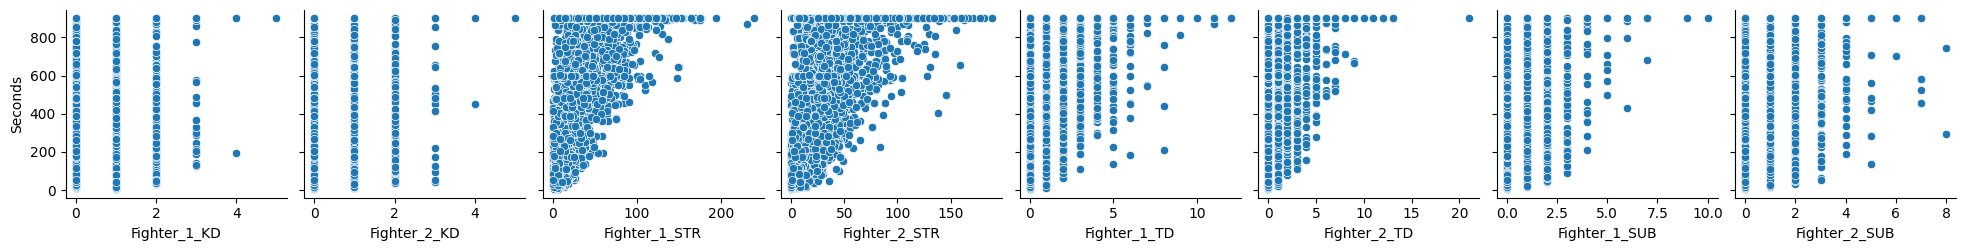

In [49]:
sns.pairplot(winrates_df_for_plot,   x_vars=['Fighter_1_KD', 'Fighter_2_KD','Fighter_1_STR',   'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD','Fighter_1_SUB', 'Fighter_2_SUB'], y_vars="Seconds")

### !!! REMOVE OUTLIERS

## MEAN OF RESIDUALS

In [50]:
predidted_time = model_Time.fit().predict(winrates_df_model)

residuals = winrates_df["Seconds"] - predidted_time

mean_of_residuals = residuals.sum()/residuals.size

mean_of_residuals

3.675923827243908e-13

OK!

## CHECK FOR HOMOSKEDASTICITY

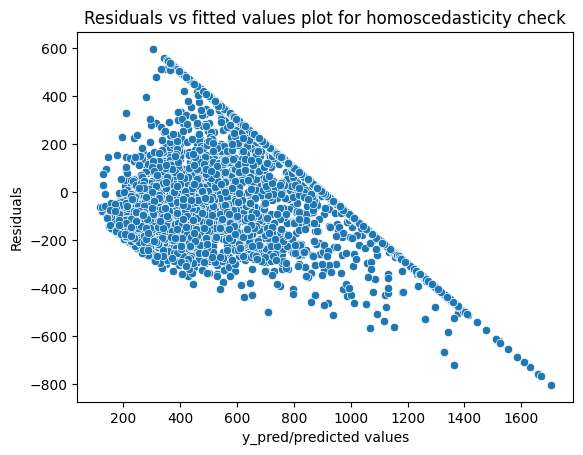

In [51]:

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Null Hypothesis: Error terms are homoscedastic

Alternative Hypothesis: Error terms are heteroscedastic.

In [52]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, winrates_df_model)
lzip(name, test)

[('F statistic', 0.9162789024130021), ('p-value', 0.9920974548174052)]

We can not reject null hypotheses

In [53]:
bartlett(predictions, residuals)

BartlettResult(statistic=527.84820583123, pvalue=8.300133850425238e-117)

In [54]:
het_white(residuals, model_Time.exog)


(1153.2332418742144,
 8.552266075739735e-143,
 7.790652379573837,
 2.726695275315338e-162)

## NORMALITY

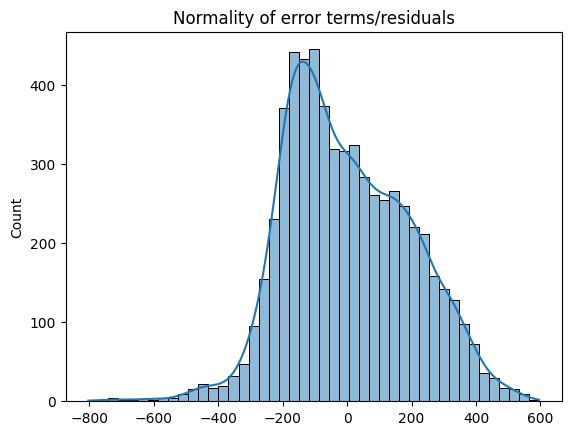

In [55]:
p = sns.histplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

Normal OK

In [56]:
normaltest(residuals)

NormaltestResult(statistic=44.64671384988855, pvalue=2.0187812848260044e-10)

Not normal 

## AUTOCORRELATION

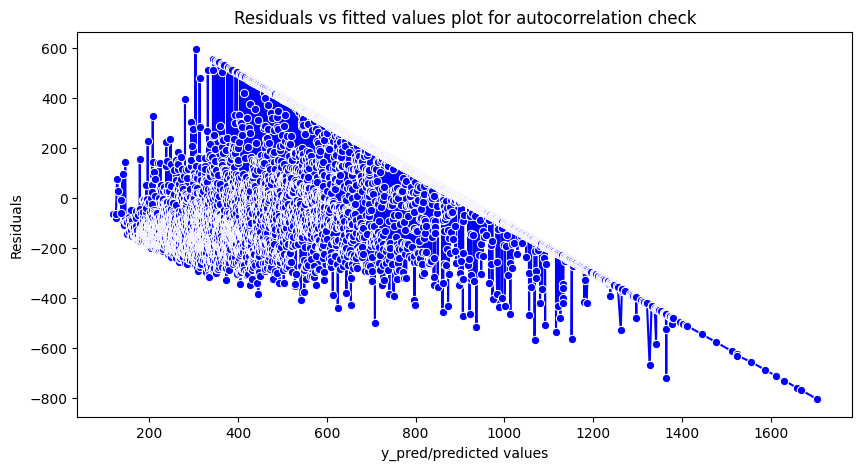

In [57]:
plt.figure(figsize=(10,5))
p = sns.lineplot(y=residuals,x=predidted_time,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

In [58]:
diag.acorr_ljungbox(residuals, lags=12)

,lb_stat,lb_pvalue
1,8.419017,3.713166e-03
2,24.068151,5.938371e-06
3,24.473142,1.989651e-05
4,39.758355,4.856196e-08
5,44.907035,1.515406e-08
6,48.164636,1.095412e-08
7,48.308597,3.098685e-08
8,51.517992,2.085111e-08
9,59.472118,1.694303e-09
10,65.548454,3.182993e-10


Not autocorrelated

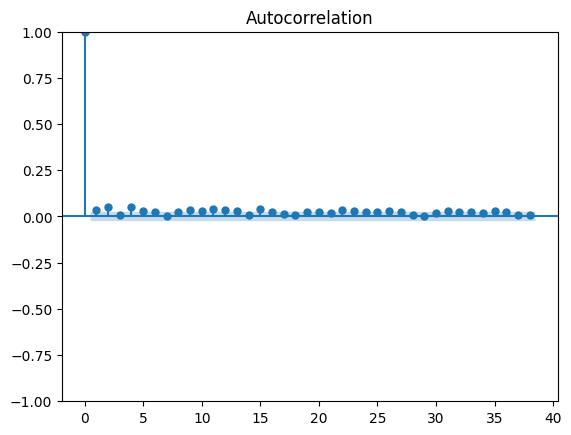

In [59]:
sm.graphics.tsa.plot_acf(residuals)
plt.show()

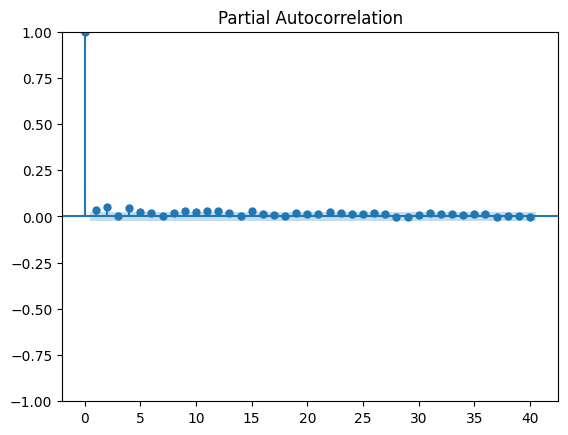

In [60]:
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

## NO PERFECT COLLINEARITY

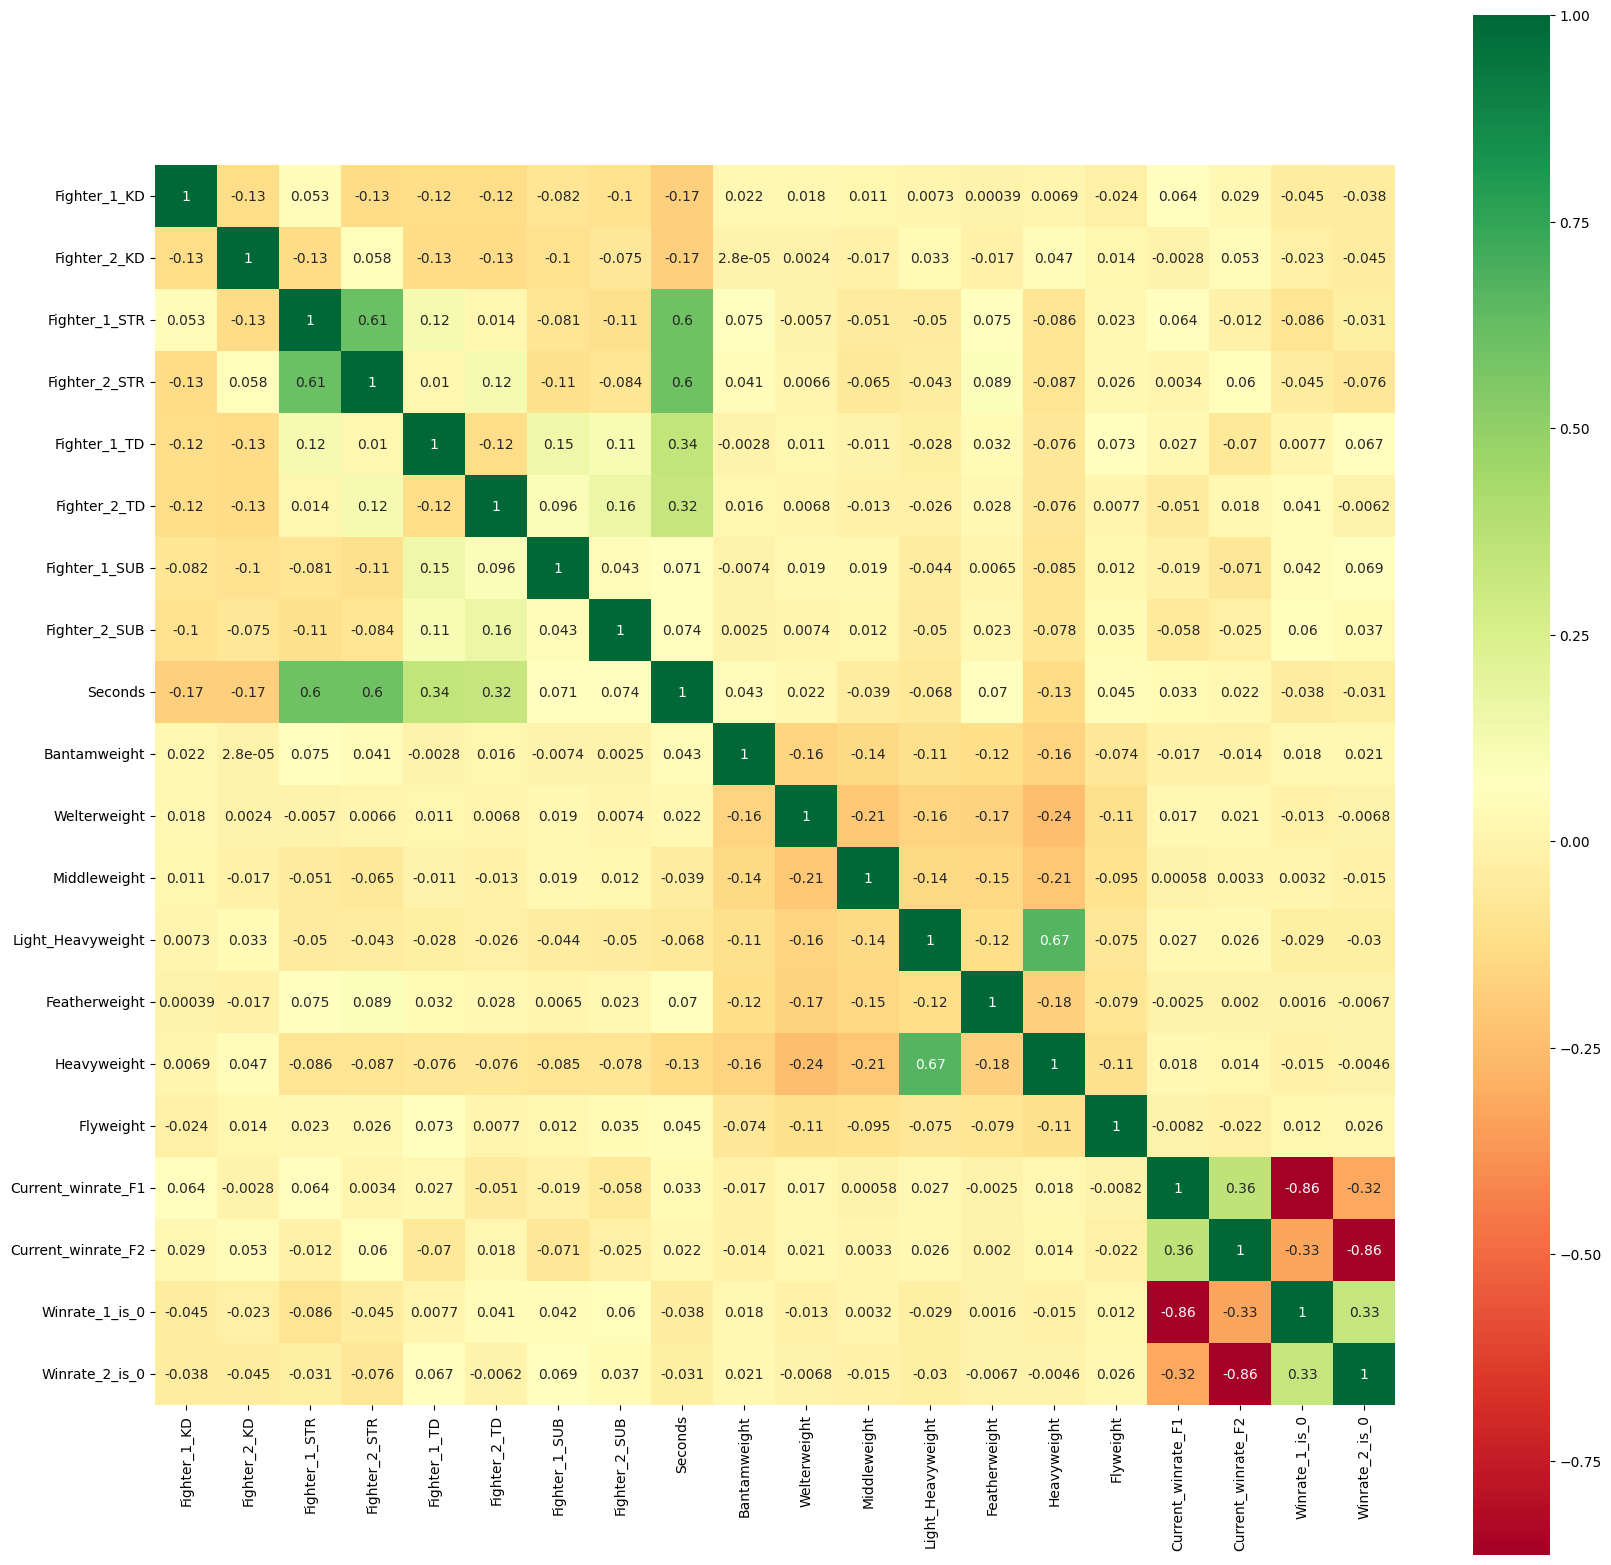

In [61]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

plt.figure(figsize=(20,20)) 
p=sns.heatmap(winrates_df_model.corr(), annot=True,cmap='RdYlGn',square=True)  

OK

## OUTLIERS CLEAN

In [62]:
winrates_df_model.columns

Index(['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB',
       'Seconds', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

<Axes: >

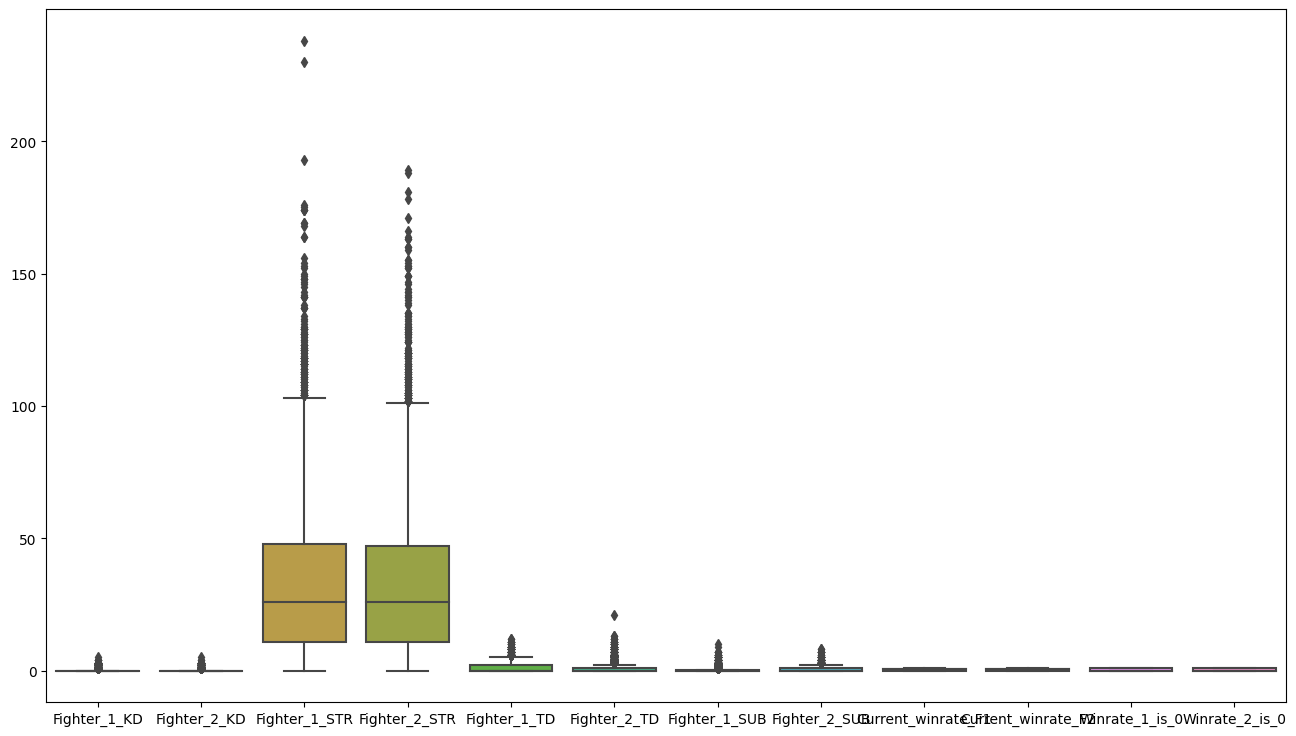

In [63]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

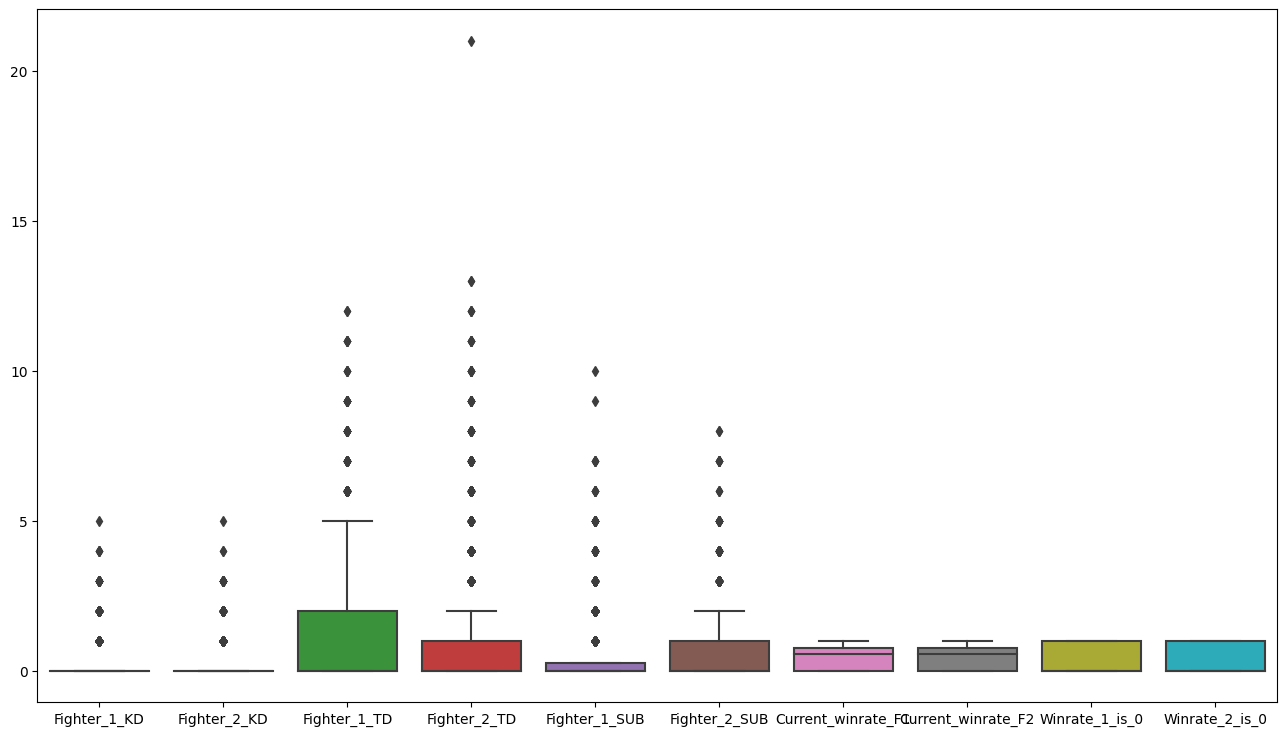

In [64]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

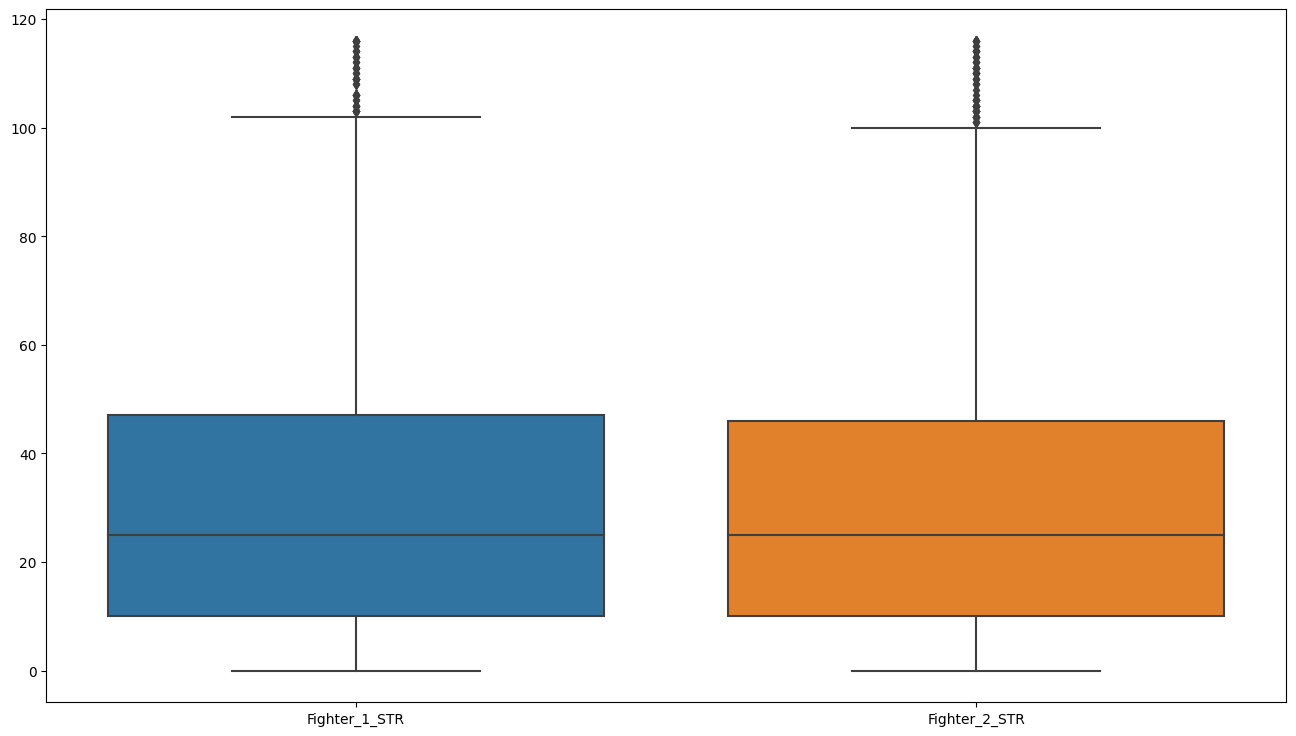

In [65]:
a = winrates_df_model[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)]

plt.figure(figsize=(16,9))
sns.boxplot(a[['Fighter_1_STR', 'Fighter_2_STR']])

In [66]:
outliners_off = a.reset_index(drop=True)

In [67]:
new_m = smf.ols(f"Seconds ~ {' + '.join(outliners_off.drop(['Seconds'], axis=1))}", data=outliners_off).fit()
new_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     604.0
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:29:23   Log-Likelihood:                -33355.
No. Observations:                5031   AIC:                         6.675e+04
Df Residuals:                    5011   BIC:                         6.688e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            149.2787     15.985      9.339      0.000     117.941     180.616
Fighter_1_KD         -75.5087      7.106    -10.626      0.000     -89.439     -61.578
Fighter_2_KD         -74.5166      7.006    -10.636      0.000     -88.251     -60.782
Fighter_1_STR          4.7898      0.137     34.935      0.000       4.521       5.059
Fighter_2_STR          4.8650      0.135     35.912      0.000       4.599       5.131
Fighter_1_TD          66.9393      2.225     30.083      0.000      62.577      71.302
Fighter_2_TD          63.9250      2.057     31.077      0.000      59.892      67.958
Fighter_1_SUB          0.0573      4.740      0.012      0.990      -9.236       9.350
Fighter_2_SUB          8.4538      4.663      1.813      0.070      -0.688      17.595
Bantamweight          -1.2823     10.272     -0.125      0.901     -21.420      18.855
Welterweight           8.6088      8.332      1.033      0.302      -7.725      24.942
Middleweight           2.9413      8.794      0.334      0.738     -14.299      20.182
Light_Heavyweight     -4.1762     11.318     -0.369      0.712     -26.365      18.012
Featherweight        -23.8649      9.825     -2.429      0.015     -43.125      -4.605
Heavyweight           -6.2160      9.881     -0.629      0.529     -25.587      13.155
Flyweight             -0.3761     13.451     -0.028      0.978     -26.745      25.993
Current_winrate_F1    24.8229     14.745      1.683      0.092      -4.083      53.729
Current_winrate_F2    25.1275     15.045      1.670      0.095      -4.368      54.623
Winrate_1_is_0         9.3388     11.670      0.800      0.424     -13.539      32.216
Winrate_2_is_0         5.8812     11.850      0.496      0.620     -17.351      29.113
==============================================================================
Omnibus:                       99.193   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.644
Skew:                           0.350   Prob(JB):                     1.89e-23
Kurtosis:                       3.095   Cond. No.                         476.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

a - norm df

1) Dummy STR remain
2)  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


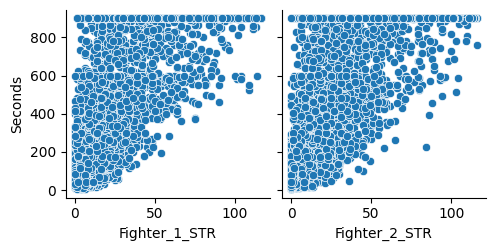

In [68]:
sns.pairplot(outliners_off,   x_vars=['Fighter_1_STR',   'Fighter_2_STR'], y_vars="Seconds")

Remove heteroskedasticity

1) Methode one:

In [69]:
for_fight_str = np.where(a['Fighter_1_STR'] <= 65, 0, 1)
for_second_str = np.where(a['Fighter_2_STR'] <= 65, 0, 1)

df_for_hetero = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

hetero_check_1 = pd.concat([outliners_off, df_for_hetero], axis=1)

In [70]:
hetero_1 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_1.drop(['Seconds'], axis=1))}", data=hetero_check_1).fit()
hetero_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     658.3
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:29:23   Log-Likelihood:                -33019.
No. Observations:                5031   AIC:                         6.608e+04
Df Residuals:                    5009   BIC:                         6.623e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             92.1160     15.108      6.097      0.000      62.497     121.735
Fighter_1_KD         -78.8578      6.671    -11.821      0.000     -91.935     -65.780
Fighter_2_KD         -82.3113      6.575    -12.519      0.000     -95.201     -69.421
Fighter_1_STR          6.5575      0.174     37.752      0.000       6.217       6.898
Fighter_2_STR          6.7272      0.173     38.787      0.000       6.387       7.067
Fighter_1_TD          58.0088      2.110     27.487      0.000      53.871      62.146
Fighter_2_TD          55.4191      1.953     28.383      0.000      51.591      59.247
Fighter_1_SUB          4.6815      4.441      1.054      0.292      -4.026      13.389
Fighter_2_SUB         11.0272      4.364      2.527      0.012       2.472      19.582
Bantamweight          -0.0986      9.612     -0.010      0.992     -18.942      18.745
Welterweight          10.7693      7.796      1.381      0.167      -4.515      26.054
Middleweight           2.9619      8.229      0.360      0.719     -13.171      19.095
Light_Heavyweight     -2.1309     10.590     -0.201      0.841     -22.893      18.631
Featherweight        -20.8497      9.193     -2.268      0.023     -38.872      -2.827
Heavyweight           -3.6204      9.246     -0.392      0.695     -21.746      14.505
Flyweight              1.0452     12.585      0.083      0.934     -23.627      25.718
Current_winrate_F1    32.4947     13.800      2.355      0.019       5.441      59.548
Current_winrate_F2    20.2403     14.079      1.438      0.151      -7.361      47.841
Winrate_1_is_0        18.4877     10.924      1.692      0.091      -2.928      39.904
Winrate_2_is_0         6.2542     11.088      0.564      0.573     -15.483      27.991
Fighter_1_Tough     -193.1114     11.354    -17.008      0.000    -215.370    -170.852
Fighter_2_Tough     -207.7155     11.452    -18.137      0.000    -230.167    -185.264
==============================================================================
Omnibus:                      126.531   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.844
Skew:                           0.367   Prob(JB):                     4.30e-31
Kurtosis:                       3.357   Cond. No.                         478.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

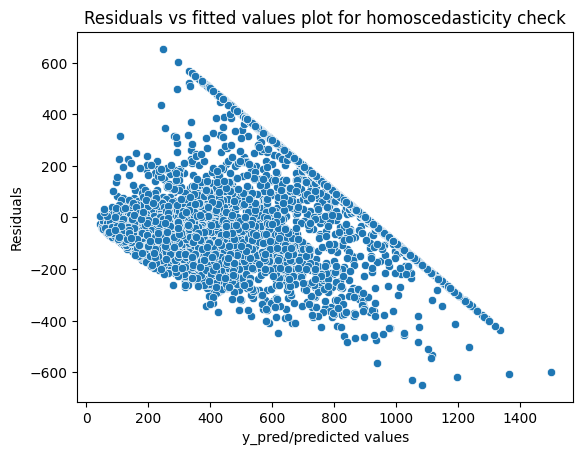

In [71]:
predidted_time = hetero_1.predict(hetero_check_1)

residuals = (hetero_check_1["Seconds"] - predidted_time).dropna()

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [72]:
hetero_21 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_1.drop(['Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight', 'Seconds'], axis=1))}", data=hetero_check_2).fit()
hetero_21.summary()

NameError: name 'hetero_check_2' is not defined

In [ ]:
predicted = hetero_21.predict(hetero_check_1)

residuals = hetero_check_1['Seconds'] - predicted

mean_er = residuals.sum()/residuals.shape[0]

mean_er

1.182306978228455e-12

## Logit model updated

In [ ]:
def improve_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Improve the dataframe ability to construct good OLS models
    """
    outlieners_off = df[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)].reset_index(drop=True)
    
    for_fight_str = np.where(outlieners_off['Fighter_1_STR'] <= 65, 0, 1)
    for_second_str = np.where(outlieners_off['Fighter_2_STR'] <= 65, 0, 1)

    df_for_tough = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

    tough_df = pd.concat([outlieners_off, df_for_tough], axis=1)

    result = tough_df.drop(['Lightweight','Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight'], axis=1).reset_index(drop=True)

    return result
        

In [ ]:
test = improve_df(winrates_df)
test

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Method,Winner,Seconds,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0,Fighter_1_Tough,Fighter_2_Tough
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,KO/TKO Punch,1,64.0,0.88,0.77,0,0,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,KO/TKO Punches,0,169.0,0.59,0.56,0,0,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,U-DEC,0,900.0,0.75,0.75,0,0,0,0
3,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,U-DEC,1,900.0,0.56,0.53,0,0,0,0
4,Punahele Soriano,Dustin Stoltzfus,0.0,1.0,31.0,64.0,0.0,4.0,0.0,1.0,SUB Rear Naked Choke,0,550.0,0.50,0.20,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,Adriano Santos,Tulio Palhares,0.0,0.0,11.0,31.0,2.0,4.0,0.0,0.0,KO/TKO Punches,0,540.0,0.00,0.00,1,1,0,0
5030,Mark Coleman,Pete Williams,0.0,1.0,26.0,22.0,3.0,0.0,0.0,1.0,KO/TKO Kick,0,338.0,0.00,0.00,1,1,0,0
5031,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,KO/TKO Punches,1,43.0,0.00,0.00,1,1,0,0
5032,Joe Pardo,Mike van Arsdale,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,SUB Keylock,0,661.0,0.00,0.00,1,1,0,0


In [76]:
winrates_df.loc[(winrates_df["Fighter_1"] == "Conor McGregor") | (winrates_df["Fighter_2"] == "Conor McGregor")]['Seconds']

935     300.0
1116    452.0
1464     40.0
2707    484.0
2965    552.0
3055     13.0
3236    597.0
3429    414.0
3556    106.0
3635    245.0
4042    900.0
4164     67.0
Name: Seconds, dtype: float64

In [ ]:
winrates_df_model_logit = test.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=test)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.324540
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 5034
Model:                          Logit   Df Residuals:                     5019
Method:                           MLE   Df Model:                           14
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.5317
Time:                        21:40:36   Log-Likelihood:                -1633.7
converged:                       True   LL-Null:                       -3488.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2231      0.257      0.868      0.385      -0.281       0.727
Fight

Optimization terminated successfully.
         Current function value: 0.324540
         Iterations 7


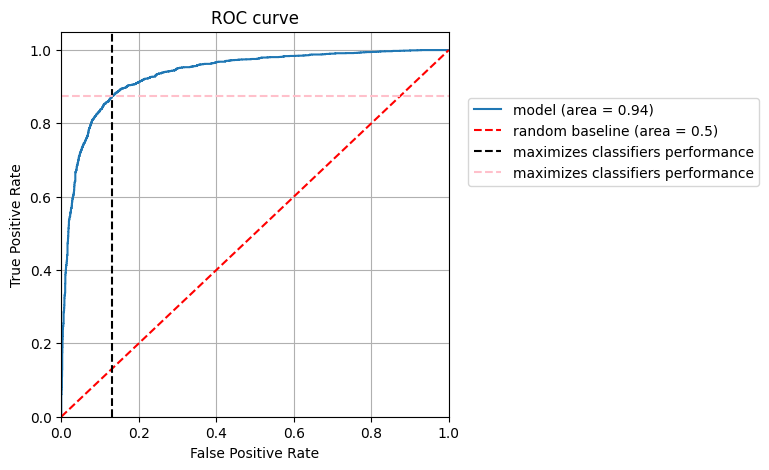

In [ ]:
def plot_roc_curve(y_true, y_pred_prob):

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_true=y_true, y_score=y_pred_prob), 2)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f'model (area = {auc})')
    plt.plot([0, 1], [0, 1], 'r--', label='random baseline (area = 0.5)')

    id_x = pd.Series(abs(tpr - fpr), index=fpr).idxmax()
    plt.axvline(x=id_x, linestyle='dashed', color='black',
                label='maximizes classifiers performance')
    id_y = pd.Series(abs(tpr - fpr), index=tpr).idxmax()
    plt.axhline(y=id_y, linestyle='dashed', color='pink',
                label='maximizes classifiers performance')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc=(1.05, 0.6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

y_pred = model_logit.fit().predict(test)

plot_roc_curve(test['Winner'], y_pred)

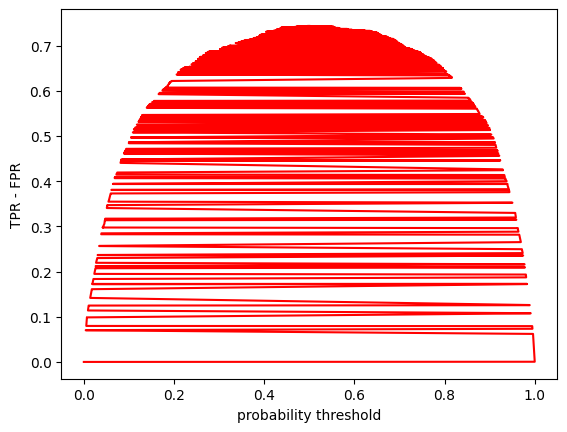

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test['Winner'], y_pred)
df2 = pd.DataFrame()
df2['tpr'] = tpr
df2['fpr'] = fpr
df2['obj'] = abs(tpr - fpr)
df2['thresholds'] = thresholds
df2 = df2.sort_values('obj', ascending=False).copy()

df2 = df2[df2.thresholds < 1]
plt.plot(df2['thresholds'], df2['obj'], color='red')
plt.ylabel('TPR - FPR')
plt.xlabel('probability threshold')
plt.show()

In [ ]:
df2.sort_values('obj', ascending=False)

,tpr,fpr,obj,thresholds
516,0.873626,0.129928,0.743699,0.499995
518,0.874411,0.130732,0.743679,0.497625
520,0.874804,0.131134,0.743669,0.496150
519,0.874411,0.131134,0.743277,0.497493
517,0.873626,0.130732,0.742894,0.499300
...,...,...,...,...
5,0.062402,0.000805,0.061597,0.996273
2,0.060832,0.000000,0.060832,0.996355
3,0.060832,0.000402,0.060430,0.996332
1,0.000392,0.000000,0.000392,0.999995


In [ ]:
metrics.f1_score(test['Winner'], np.where(y_pred < 0.5, 0, 1))

0.8732339089481946